In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def smma(series,n):

    output=[series[0]]

    for i in range(1,len(series)):
        temp=output[-1]*(n-1)+series[i]
        output.append(temp/n)

    return output

In [3]:
def rsi(data,n=14):

    delta=data.diff().dropna()

    up=np.where(delta>0,delta,0)
    down=np.where(delta<0,-delta,0)

    rs=np.divide(smma(up,n),smma(down,n))

    output=100-100/(1+rs)

    return output[n-1:]

In [4]:
def signal_generation(df,method,n=14):

    df['rsi']=0.0
    df['rsi'][n:]=method(df['Close'],n=14)

    df['positions']=np.select([df['rsi']<30,df['rsi']>70], \
                              [1,-1],default=0)
    df['signals']=df['positions'].diff()

    return df[n:]

In [5]:
def plot(new,ticker):

    #the first plot is the actual close price with long/short positions
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(211)

    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,
            new['Close'][new['signals']==1],
            label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,
            new['Close'][new['signals']==-1],
            label='SHORT',lw=0,marker='v',c='r')


    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')

    plt.show()

    #the second plot is rsi with overbought/oversold interval capped at 30/70
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    new['rsi'].plot(label='relative strength index',c='#522e75')
    bx.fill_between(new.index,30,70,alpha=0.5,color='#f22f08')

    bx.text(new.index[-45],75,'overbought',color='#594346',size=12.5)
    bx.text(new.index[-45],25,'oversold',color='#594346',size=12.5)

    plt.xlabel('Date')
    plt.ylabel('value')
    plt.title('RSI')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [6]:
def pattern_recognition(df,method,lag=14):

    df['rsi']=0.0
    df['rsi'][lag:]=method(df['Close'],lag)

    #as usual, period is defined as the horizon for finding the pattern
    period=25

    #delta is the threshold of the difference between two prices
    #if the difference is smaller than delta
    #we can conclude two prices are not significantly different from each other
    #the significant level is defined as delta
    delta=0.2

    #these are the multipliers of delta
    #we wanna make sure there is head and shoulders are significantly larger than other nodes
    #the significant level is defined as head/shoulder multiplier*delta
    head=1.1
    shoulder=1.1

    df['signals']=0
    df['cumsum']=0
    df['coordinates']=''

    #now these are the parameters set by us based on experience
    #entry_rsi is the rsi when we enter a trade
    #we would exit the trade based on two conditions
    #one is that we hold the stock for more than five days
    #the variable for five days is called exit_days
    #we use a variable called counter to keep track of it
    #two is that rsi has increased more than 4 since the entry
    #the variable for 4 is called exit_rsi
    #when either condition is triggered, we exit the trade
    #this is a lazy way to exit the trade
    #cuz i dont wanna import indicators from other scripts
    #i would suggest people to use other indicators such as macd or bollinger bands
    #exiting trades based on rsi is definitely inefficient and unprofitable
    entry_rsi=0.0
    counter=0
    exit_rsi=4
    exit_days=5

    #signal generation
    #plz refer to the following link for pattern visualization
    # https://github.com/je-suis-tm/quant-trading/blob/master/preview/rsi%20head-shoulder%20pattern.png
    #the idea is to start with the first node i
    #we look backwards and find the head node j with maximum value in pattern finding period
    #between node i and node j, we find a node k with its value almost the same as node i
    #started from node j to left, we find a node l with its value almost the same as node i
    #between the left beginning and node l, we find a node m with its value almost the same as node i
    #after that, we find the shoulder node n with maximum value between node m and node l
    #finally, we find the shoulder node o with its value almost the same as node n
    for i in range(period+lag,len(df)):

        #this is pretty much the same idea as in bollinger bands
        #except we have two variables
        #one for shoulder and one for the bottom nodes
        moveon=False
        top=0.0
        bottom=0.0

        #we have to make sure no holding positions
        #and the close price is not the maximum point of pattern finding horizon
        if (df['cumsum'][i]==0) and  \
        (df['Close'][i]!=max(df['Close'][i-period:i])):

            #get the head node j with maximum value in pattern finding period
            #note that dataframe is in datetime index
            #we wanna convert the result of idxmax to a numerical index number
            j=df.index.get_loc(df['Close'][i-period:i].idxmax())

            #if the head node j is significantly larger than node i
            #we would move on to the next phrase
            if (np.abs(df['Close'][j]-df['Close'][i])>head*delta):
                bottom=df['Close'][i]
                moveon=True

            #we try to find node k between node j and node i
            #if node k is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                for k in range(j,i):
                    if (np.abs(df['Close'][k]-bottom)<delta):
                        moveon=True
                        break

            #we try to find node l between node j and the end of pattern finding horizon
            #note that we start from node j to the left
            #cuz we need to find another bottom node m later which would start from the left beginning
            #this way we can make sure we would find a shoulder node n between node m and node l
            #if node l is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                for l in range(j,i-period+1,-1):
                    if (np.abs(df['Close'][l]-bottom)<delta):
                        moveon=True
                        break

            #we try to find node m between node l and the end of pattern finding horizon
            #this time we start from left to right as usual
            #if node m is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                for m in range(i-period,l):
                    if (np.abs(df['Close'][m]-bottom)<delta):
                        moveon=True
                        break

            #get the shoulder node n with maximum value between node m and node l
            #note that dataframe is in datetime index
            #we wanna convert the result of idxmax to a numerical index number
            #if node n is significantly larger than node i and significantly smaller than node j
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                n=df.index.get_loc(df['Close'][m:l].idxmax())
                if (df['Close'][n]-bottom>shoulder*delta) and \
                (df['Close'][j]-df['Close'][n]>shoulder*delta):
                    top=df['Close'][n]
                    moveon=True

            #we try to find shoulder node o between node k and node i
            #if node o is not significantly different from node n
            #we would set up the signals and coordinates for visualization
            #we also need to refresh cumsum and entry_rsi for exiting the trade
            #note that moveon is still set as True
            #it would help the algo to ignore this round of iteration for exiting the trade
            if moveon==True:
                for o in range(k,i):
                    if (np.abs(df['Close'][o]-top)<delta):
                        df.at[df.index[i],'signals']=-1
                        df.at[df.index[i],'coordinates']='%s,%s,%s,%s,%s,%s,%s'%(m,n,l,j,k,o,i)
                        df['cumsum']=df['signals'].cumsum()
                        entry_rsi=df['rsi'][i]
                        moveon=True
                        break

        #each time we have a holding position
        #counter would steadily increase
        #if either of the exit conditions is met
        #we exit the trade with long position
        #and we refresh counter, entry_rsi and cumsum
        #you may wonder why do we need cumsum?
        #well, this is for holding positions in case you wanna check on portfolio performance
        if entry_rsi!=0 and moveon==False:
            counter+=1
            if (df['rsi'][i]-entry_rsi>exit_rsi) or \
            (counter>exit_days):
                df.at[df.index[i],'signals']=1
                df['cumsum']=df['signals'].cumsum()
                counter=0
                entry_rsi=0

    return df


In [7]:
def pattern_plot(new,ticker):

    #this part is to get a small slice of dataframe
    #so we can get a clear view of head-shoulder pattern
    a,b=list(new[new['signals']!=0].iloc[2:4].index)

    #extract coordinates for head-shoulder pattern visualization
    temp=list(map(int,new['coordinates'][a].split(',')))
    indexlist=list(map(lambda x:new.index[x],temp))

    #slicing
    c=new.index.get_loc(b)
    newbie=new[temp[0]-30:c+20]

    #first plot is always price with positions
    ax=plt.figure(figsize=(10,10)).add_subplot(211)

    newbie['Close'].plot(label=ticker)
    ax.plot(newbie['Close'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    ax.plot(newbie['Close'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')

    plt.legend(loc=0)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()

    #second plot is head-shoulder pattern on rsi
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)

    newbie['rsi'].plot(label='relative strength index',c='#f4ed71')

    #we plot the overbought/oversold interval, positions and pattern
    bx.fill_between(newbie.index,30,70,alpha=0.6,label='overbought/oversold range',color='#000d29')
    bx.plot(newbie['rsi'][indexlist], \
            lw=3,alpha=0.7,marker='o', \
            markersize=6,c='#8d2f23',label='head-shoulder pattern')
    bx.plot(newbie['rsi'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    bx.plot(newbie['rsi'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')

    #put some captions on head and shoulders
    for i in [(1,'Shoulder'),(3,'Head'),(5,'Shoulder')]:
        plt.text(indexlist[i[0]], newbie['rsi'][indexlist[i[0]]]+2, \
             '%s'%i[1],fontsize=10,color='#e4ebf2', \
             horizontalalignment='center', \
            verticalalignment='center')

    plt.title('RSI')
    plt.legend(loc=1)
    plt.xlabel('Date')
    plt.ylabel('value')
    plt.grid(True)
    plt.show()

In [10]:
def main():

    ticker='FCAU'
    startdate='2016-01-01'
    enddate='2019-07-22'
    df=yf.download(ticker,start=startdate,end=enddate)
    new=signal_generation(df,rsi,n=14)

    plot(new,ticker)

[*********************100%***********************]  1 of 1 downloaded


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


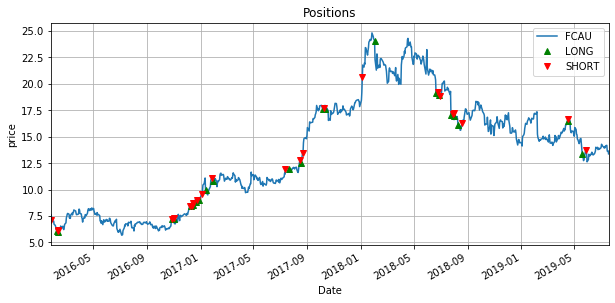

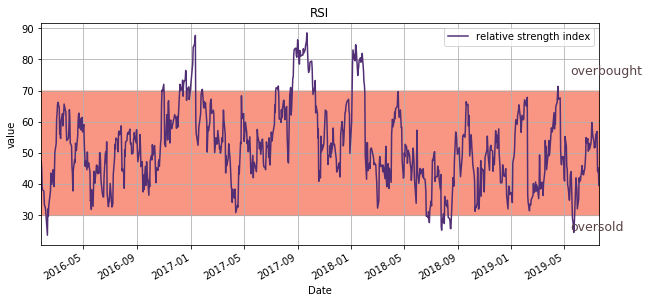

In [11]:
if __name__ == '__main__':
    main()